In [1]:
import numpy as np
import pandas as pd
import nltk
import seaborn as sns
from matplotlib import pyplot as plt
from wordcloud import WordCloud

The following blocks of code define various metrics through which error may be measured. They will be used to evaluate our data on the test set.

In [2]:
def ConfusionMatrix(expected, predicted, p='spam'):
    # TP occurs when our prediction aligns with actual data, and prediction is p.
    TP = np.where(((predicted == expected) & (p == predicted)), 1, 0).sum()
    # FP occurs when our prediction is incorrect, but prediction is still p.
    FP = np.where(((predicted != expected) & (p == predicted)), 1, 0).sum()
    # TN occurs when our prediction is correct and is not p.
    TN = np.where(((predicted == expected) & (p != predicted)), 1, 0).sum()
    # FN occurs when our prediction is incorrect, and we predict not p.
    FN = np.where(((predicted != expected) & (p != predicted)), 1, 0).sum()
    # Put values into a matrix, return confusion matrix.
    confusion_matrix = np.array([[TP, FP],
                                 [FN, TN]])
    return confusion_matrix

def F1_Score(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 'spam'))
    return cm[0][0]/(cm[0][0] + (cm[1][0] + cm[0][1])/2)

def Accuracy(expected, predicted):
    if isinstance(expected, pd.DataFrame):
        correct = np.where(expected.values == predicted.values, 1, 0).sum()
    else:
        correct = np.where(expected == predicted, 1, 0).sum()
    accuracy = correct/expected.size
    return accuracy

def Recall(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 'spam'))
    return cm[0][0]/(cm[0][0] + cm[1][0])

def Precision(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 'spam'))
    return cm[0][0]/(cm[0][0] + cm[0][1])

def mse(Y_true, Y_pred):
    sq_diff = np.array([])
    for (yt, yp) in zip(Y_true, Y_pred):
        sq_diff = np.append(sq_diff, (yp - yt)**2)
    return (1/Y_true.size)*sq_diff.sum()

The sFold function splits data up into training and validation sets iteratively, until all sets have served as validation set once. It reports the average error across all validation sets.

In [17]:
def sFold(folds, data, labels, model, error_function, **model_args):
    # Check for kwargs which must be inputted manually into KNN_Classifier.
    alpha = model_args.pop('alpha', 1.0)
    def s_partition(folds, data, labels):
        parts = {}
        rng = np.random.randint(0, folds, size=labels.size)
        for s in range(folds):
            parts[s] = (data.loc[rng == s], labels.loc[rng == s])
        return parts
    
    # Split data.
    parts = s_partition(folds, data, labels)

    # Initialize output dictionary.
    output = {'expected': np.array([]), 'predicted': np.array([]), 'average error': np.nan}
    # Run through each partition, isolating them one-by-one.
    for iso in parts:
        # Need to copy dict to drop the isolated part.
        without_iso = parts.copy()
        without_iso.pop(iso)
        # Need to accumulate all the data for non-isolated parts.
        data_wo_iso = pd.DataFrame()
        labels_wo_iso = pd.Series()
        for part in without_iso:
            data_wo_iso = pd.concat((data_wo_iso, without_iso[part][0]), axis=0)
            labels_wo_iso = pd.concat((labels_wo_iso, without_iso[part][1]), axis=0)
        model_class = model(alpha)
        # Make our knn model, fit it to the accumulated, non-isolated parts.
        model_class.fit(X=data_wo_iso, Y=labels_wo_iso)
        # Prediction of current partition. Actual target is parts[iso][1].
        predicted = model_class.predict(parts[iso][0])
        expected = parts[iso][1]
        # Calculate the error for this run.
        # Store everything in the output dict. Label dict by isolated part.
        print(expected.shape)
        output['expected'] = np.concatenate((output['expected'], expected), axis=0)
        output['predicted'] = np.concatenate((output['predicted'], predicted), axis=0)
    # Get error across all partition predictions.
    output['average error'] = error_function(output['expected'], output['predicted'])
    return output

# PART I
## PART A
The multinomial Bayes classifier is defined below. It classifies our texts either as spam or ham, with spam treated as the value of interest (index 0).

In [4]:
class Multinomial_NB:
    # Function for part (a).
    def __init__(self, alpha=1.0):
        self.alpha = alpha
    
    # Function for part (b).
    def fit(self, X, Y):
        self.X = X.to_numpy()
        self.Y = Y.to_numpy()
        
        # Split data, for easier counting.
        spam = self.X[np.where(self.Y == 'spam')]
        ham = self.X[np.where(self.Y == 'ham')]
        
        # Gather counts for pi.
        N_spam = spam.shape[0]
        N_ham = ham.shape[0]
        N = self.Y.shape[0]
        
        # Define pi in both domains.
        self.pi_spam = (self.alpha + N_spam)/(2*self.alpha + N)
        self.pi_ham = (self.alpha + N_ham)/(2*self.alpha + N)
        
        # Gather counts for theta.
        M_feature_spam = spam.sum(axis=0)
        M_feature_ham = ham.sum(axis=0)
        M_spam = (spam.sum(axis=0) > 0).sum()
        M_ham = (ham.sum(axis=0) > 0).sum()
        vocabulary = self.X.shape[1]
        
        # Define theta in both domains.
        self.theta_spam = (self.alpha + M_feature_spam)/(vocabulary + M_spam)
        self.theta_ham = (self.alpha + M_feature_ham)/(vocabulary + M_ham)
        
        # Concatenate pi and theta into a singular array.
        self.pi = np.array([self.pi_spam, self.pi_ham])
        self.theta = np.array([self.theta_spam, self.theta_ham])
    
    # Function for part (d).
    def predict_log_proba(self, X):
        ''' This function returns log-probabilities of every instance in X for both classes (spam and ham). A
        more efficient implementation probably exists in pure numpy which doesn't require looping, but I had 
        trouble getting it to work, and so I reverted to a looping method instead. It still runs quickly! '''
        X = X.to_numpy()
        probs = np.full(shape=(X.shape[0], self.pi.size), fill_value=-np.inf)
        for instance in range(X.shape[0]):
            features = np.where(X[instance] > 0)
            for target in range(self.pi.size):
                probs[instance, target] = np.log(self.pi[target]) + np.sum(np.log(self.theta[target, features]))
        return probs

    # Function for part (e), extra credit.
    def predict_proba(self, X):
        return np.exp(self.predict_log_proba(X))
    
    # Function for part (c).
    def predict(self, X):
        probs = self.predict_log_proba(X)
        preds = np.where(probs[:, 0] > probs[:, 1], 'spam', 'ham')
        return preds

## PART B
We now do some EDA to get our data into a good format for our Bayes classifier.

In [5]:
#2, getting data and shuffling it (#9).
df = pd.read_csv('SMSSpamCollection.csv', sep='\t', names=['Class', 'Text'])
df = df.sample(frac=1)
df

,Class,Text
1979,ham,No I'm in the same boat. Still here at my moms...
2403,ham,Oh oh... Wasted... Den muz chiong on sat n sun...
5167,ham,Oh did you charge camera
3869,ham,"not that I know of, most people up here are st..."
5437,ham,Am slow in using biola's fne
...,...,...
4163,ham,How's it going? Got any exciting karaoke type ...
1792,ham,U havent lost me ill always b here 4u.i didn...
5056,ham,Am on a train back from northampton so i'm afr...
428,ham,Any pain on urination any thing else?


In [6]:
#3, summarizing variables in the dataset, using technique from first recitation and NLP recitation.
df['Length'] = df['Text'].map(lambda text: len(text))
df.groupby('Class').Length.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
ham,4825.0,71.482487,58.440652,2.0,33.0,52.0,93.0,910.0
spam,747.0,138.670683,28.873603,13.0,133.0,149.0,157.0,223.0


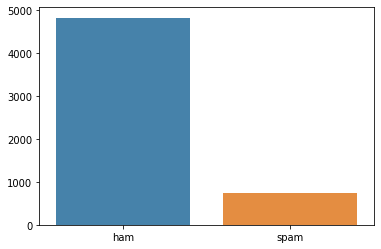

In [7]:
#4, generating bar plot to display distributions.
label_counts = df.Class.value_counts()
sns.barplot(label_counts.index, label_counts.values, alpha=0.9)

In [8]:
#5 text normalization, both lemmatization and stemming.
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer
lemmatizer = WordNetLemmatizer()
df_lemmatized = df.copy(deep=True)

for row, i in zip(df_lemmatized['Text'], range(len(df_lemmatized))):
    wordify = nltk.word_tokenize(row)
    for j in range(len(wordify)):
        wordify[j] = wordify[j].lower()
    df_lemmatized['Text'].iloc[i] = ' '.join([lemmatizer.lemmatize(w) for w in wordify])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MatAdamec\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MatAdamec\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\MatAdamec\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [9]:
stemmer = PorterStemmer()
df_stemmed = df.copy(deep=True)

for row, i in zip(df_stemmed['Text'], range(len(df_stemmed))):
    wordify = nltk.word_tokenize(row)
    df_stemmed['Text'].iloc[i] = ' '.join([stemmer.stem(w) for w in wordify])

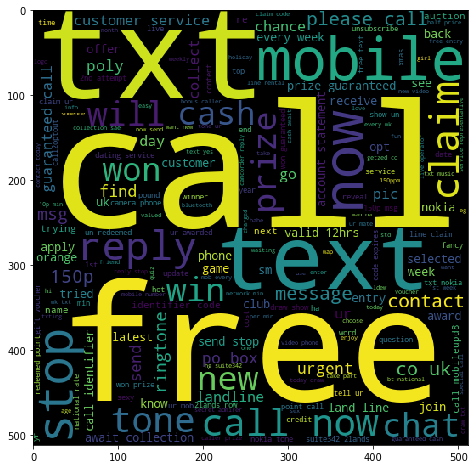

In [10]:
#6, spam word cloud.
spam_words = ''.join(list(df_lemmatized[df_lemmatized['Class']=='spam']['Text']))
spam_wordcloud = WordCloud(width = 512, height = 512).generate(spam_words)
plt.figure(figsize=(10,8))
plt.imshow(spam_wordcloud)

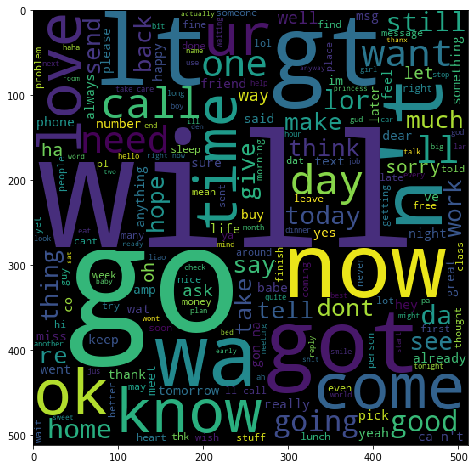

In [11]:
#6, ham word cloud.
ham_words = ''.join(list(df_lemmatized[df_lemmatized['Class']=='ham']['Text']))
ham_wordcloud = WordCloud(width = 512, height = 512).generate(ham_words)
plt.figure(figsize=(10,8))
plt.imshow(ham_wordcloud)

In [12]:
#7 removing stop words and getting numerical feature vectors.
from sklearn.feature_extraction.text import CountVectorizer
lemma_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
lemma_counts = lemma_vectorizer.fit_transform(df_lemmatized['Text'])
stem_vectorizer = CountVectorizer(lowercase=True, stop_words='english')
stem_counts = stem_vectorizer.fit_transform(df_stemmed['Text'])

len(lemma_vectorizer.vocabulary_), lemma_counts.toarray().shape, lemma_counts.toarray()[0, 4045], lemma_vectorizer.vocabulary_

(7963,
 (5572, 7963),
 0,
 {'boat': 1522,
  'mom': 4739,
  'check': 1868,
  'yo': 7918,
  'half': 3460,
  'naked': 4852,
  'oh': 5088,
  'wasted': 7625,
  'den': 2381,
  'muz': 4832,
  'chiong': 1916,
  'sat': 6124,
  'sun': 6822,
  'liao': 4270,
  'did': 2445,
  'charge': 1848,
  'camera': 1744,
  'know': 4136,
  'people': 5321,
  'town': 7216,
  'slow': 6448,
  'using': 7447,
  'biola': 1468,
  'fne': 3061,
  'purity': 5697,
  'friendship': 3157,
  'smiling': 6471,
  'reading': 5797,
  'forwarded': 3111,
  'message': 4631,
  'just': 4047,
  'seeing': 6198,
  'gud': 3422,
  'evng': 2828,
  'really': 5808,
  'hope': 3648,
  'work': 7805,
  'doesnt': 2536,
  'stressful': 6739,
  'gr8': 3364,
  'day': 2317,
  'january': 3959,
  'male': 4511,
  'sale': 6094,
  'hot': 3666,
  'gay': 3239,
  'chat': 1858,
  'cheaper': 1864,
  '08709222922': 104,
  'national': 4873,
  'rate': 5774,
  '5p': 643,
  'min': 4659,
  'cheap': 1863,
  '8p': 818,
  'peak': 5310,
  'stop': 6717,
  'text': 7012,
  '08

In [13]:
#8, dividing into feature matrix and target vector.
X_lemma = pd.DataFrame(lemma_counts.toarray())
X_stem = pd.DataFrame(stem_counts.toarray())
y = df['Class']

In [14]:
def partition(feature_matrix, target_vector, t):
    # Generate a random range of values between 0 and 1.
    rng = np.random.random(target_vector.size)
    # If the number generated above is > t, put in training, else put in test.
    rng_over_t = np.where(rng > t, True, False)
    # Apply mask to features.
    train_features = feature_matrix[rng_over_t]
    test_features = feature_matrix[~rng_over_t]
    # Apply mask to target.
    train_target = target_vector[rng_over_t]
    test_target = target_vector[~rng_over_t]
    return train_features, test_features, train_target, test_target

In [15]:
#10, partitioning data. #9 was already done above; shuffling was the first thing we did.
train_features, test_features, train_target, test_target = partition(X_lemma, y, 0.2)

## PART C
We now do some basic evaluations on our model, and take metrics on the test set once an ideal model has been found (ideal judged by validation F1 score in sFold partitioning).

In [18]:
model_tests = {'alpha=0.0001': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=0.0001),
              'alpha=0.001': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=0.001),
              'alpha=0.01': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=0.01),
              'alpha=0.1': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=0.1),
              'alpha=0.5': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=0.5),
              'alpha=1.0': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=1.0),
              'alpha=1.5': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=1.5),
              'alpha=2.0': sFold(4, train_features, train_target, Multinomial_NB, F1_Score, alpha=2.0)}
model_tests

C:\Users\MatAdamec\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


(1066,)
(1083,)
(1091,)
(1187,)


KeyboardInterrupt: 

In [ ]:
best_bayes = (None, 0)
for key in model_tests:
    if model_tests[key]['average error'] > best_bayes[1]:
        best_bayes = (key, model_tests[key]['average error'])
print(best_bayes)

In [ ]:
#12 (extra credit), generating ROC curve. We don't have a threshold here, but I graphed with different
# values of alpha. A value of 0 gets 0 TPR and FPR, because of the overfitting problems that MLE has
# and a value of <10000 seems to get us to 1 TPR and FPR, and so an ROC curve was possible.
from scipy import integrate
def TPR(expected, predicted, **kwargs):
    return Recall(expected, predicted, **kwargs)

def FPR(expected, predicted, **kwargs):
    cm = ConfusionMatrix(expected, predicted, kwargs.pop('p', 'spam'))
    return cm[0][1]/(cm[0][1] + cm[1][1])

def ROC(TPR, FPR):
    plt.axis([0, 1, 0, 1])
    plt.title('ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    return plt.plot(FPR, TPR)

def AUC(TPR, FPR):
    auc = integrate.trapz(TPR, FPR)
    return np.abs(auc)

alphas = [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0]
TPRs = np.array([])
FPRs = np.array([])
recalls = np.array([])
precisions = np.array([])

expected = test_target
for alpha in alphas:
    bayes = Multinomial_NB(alpha)
    bayes.fit(train_features, train_target)
    predicted = bayes.predict(test_features)
    
    TPRs = np.append(TPRs, TPR(expected, predicted))
    FPRs = np.append(FPRs, FPR(expected, predicted))
    
ROC(TPRs, FPRs)
print('AUC:', AUC(TPRs, FPRs))

In [ ]:
#13, taking best model and evaluating on test data, using various test metrics.
best_model = Multinomial_NB(alpha=0.1)
best_model.fit(train_features, train_target)
preds = best_model.predict(test_features)
prec = Precision(test_target, preds)
print('Precision: ', prec)
rec = Recall(test_target, preds)
print('Recall: ', rec)
F1 = F1_Score(test_target, preds)
print('F1: ', F1)
cm = ConfusionMatrix(test_target, preds)
print('Confusion Matrix: ', cm)
acc = Accuracy(test_target, preds)
print('Accuracy: ', acc)

# PART II
## PART A

Okay, now we implement logistic regression. In order to do this we need to be able to implement one hot labels (as we're doing three-class classification), softscore (for softmax regression), and cross-entropy loss (for use in the gradient descent function).

In [ ]:
#15, one hot labels converts a target into n columns of 1's and 0's, where n is the amount of classes in the target.
def one_hot_labels(Y):
    Y = Y.to_numpy()
    n = np.unique(Y).size
    one_hot_y = np.zeros(shape=(Y.shape[0], n))
    for i in range(Y.shape[0]):
        j = Y[i]
        one_hot_y[i][j] = 1
    return pd.DataFrame(one_hot_y)